In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import pandas_datareader as pdr
import mplfinance as mpf
import backtrader as bt
import backtrader.feeds as btfeeds

In [2]:
#串接api抓取資料
ARKK = pdr.get_data_tiingo('ARKK', api_key='58c634ac20862b7b585c31cd663b4f06d8ab44ac')
ARKK = ARKK.reset_index(level=[0,1])
ARKK.index = ARKK['date']
ARKK_adj = ARKK.iloc[:,7:11]
ARKK_adj.columns = ['Close','High','Low','Open']
#取得2020年的數據
ARKK_adj_2020 = ARKK_adj['2020']
#開盤價及收盤價
ARKK_adj_2020_Open = ARKK_adj_2020.Open
ARKK_adj_2020_Close = ARKK_adj_2020.Close
#當日漲跌點數
ARKK_DailyChg_2020 = ARKK_adj_2020_Close - ARKK_adj_2020_Open
# 取得每日的振幅
ARKK_Abs_DailyChg_2020 = abs(ARKK_DailyChg_2020)
# 分析振幅統計數據，以利篩選適合的K棒
ARKK_Abs_DailyChg_2020.describe()

c:\users\fetty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


count    253.000000
mean       1.242963
std        1.109608
min        0.000000
25%        0.501749
50%        0.924793
75%        1.810233
max        7.447534
dtype: float64

In [3]:
#利用K線特徵抓取Evening star出現的日期
evening_condition_1 = [0,0]
for i in range(2,len(ARKK_DailyChg_2020)):
    if (ARKK_DailyChg_2020[i-2] > 1.242) & (abs(ARKK_DailyChg_2020[i-1]) < 0.501) & ( ARKK_DailyChg_2020[i] < -0.58 ):
        evening_condition_1.append(1)
    else:
        evening_condition_1.append(0)
# condition 1 符合的次數
evening_condition_1.count(1)
# 第2根的開盤與收盤價 均大於 第1根的收盤與第3根的開盤
evening_condition_2 = [0,0]
for i in range(2, len(ARKK_adj_2020_Open)):
    if ( ARKK_adj_2020_Open[i-1] > ARKK_adj_2020_Close[i-2] ) & ( ARKK_adj_2020_Open[i-1] > ARKK_adj_2020_Open[i] ) & ( ARKK_adj_2020_Close[i-1] > ARKK_adj_2020_Close[i-2] ) & ( ARKK_adj_2020_Close[i-1] > ARKK_adj_2020_Open[i] ):
            evening_condition_2.append(1)
    else:
            evening_condition_2.append(0)
evening_condition_2.count(1)

# Evening Star Signal
evening_star_signal = []
for i in range(len(evening_condition_1)):
    if ( evening_condition_1[i] == 1 ) & ( evening_condition_2[i] == 1 ):
        evening_star_signal.append(1)
    else:
        evening_star_signal.append(0)
        
# Find Evening Star date
for i in range(len(evening_star_signal)):
    if evening_star_signal[i] == 1:
        print(ARKK_adj_2020.index[i])

2020-06-24 00:00:00+00:00


In [4]:
#計算RSI並打包為函數
#收盤價
Close = ARKK_adj.Close
#日漲跌
def RSI(Close, period=10):
    Chg = Close - Close.shift(1)
#上漲幅度
    Chg_pos = pd.Series(index=Chg.index, data=Chg[Chg>0])
    Chg_pos = Chg_pos.fillna(0)
#下跌幅度
    Chg_neg = pd.Series(index=Chg.index, data=-Chg[Chg<0])
    Chg_neg = Chg_neg.fillna(0)
#計算10日平均漲跌幅
    up_mean = []
    down_mean = []
    for i in range(period+1,len(Chg_pos)+1):
        up_mean.append(np.mean(Chg_pos.values[i-period:i]))
        down_mean.append(np.mean(Chg_neg.values[i-period:i]))
#RSI10
    rsi = []
    for i in range(len(up_mean)):
        rsi.append(100 * up_mean[i] / (up_mean[i] + down_mean[i] ))
    rsi_series = pd.Series(index = Close.index[period:],data = rsi)
    return rsi_series
RSI(Close)

date
2016-04-27 00:00:00+00:00    39.244996
2016-04-28 00:00:00+00:00    35.770725
2016-04-29 00:00:00+00:00    27.275977
2016-05-02 00:00:00+00:00    29.927187
2016-05-03 00:00:00+00:00    32.174971
                               ...    
2021-04-05 00:00:00+00:00    48.635330
2021-04-06 00:00:00+00:00    48.302175
2021-04-07 00:00:00+00:00    48.320611
2021-04-08 00:00:00+00:00    70.707965
2021-04-09 00:00:00+00:00    69.117647
Length: 1247, dtype: float64

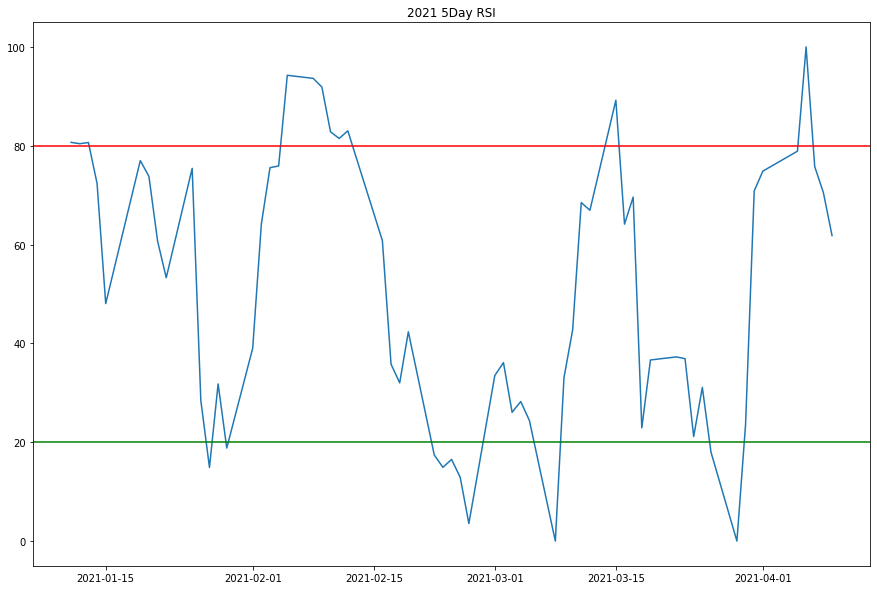

In [5]:
Close2021 = Close['2021']
RSI5_2021 = RSI(Close2021, 5)
plt.figure(figsize=(15,10))
plt.plot(RSI5_2021)
plt.title('2021 5Day RSI')
plt.axhline(y=80, color='red')
plt.axhline(y=20, color='green')

In [9]:
#低於20進場 大於等於80出場
sig = []
#庫存表示欄位 非0即1 要嘛持有要嘛全出
stock = 0
#偵測信號(偵測到信號會是隔日交易)
for i in range(len(RSI5_2021)):
    if RSI5_2021[i] >= 80 and stock ==1:
        stock = stock -1
        sig.append(-1)
    elif RSI5_2021[i] <= 20 and stock ==0:
        stock = stock +1
        sig.append(1)
    else:
        sig.append(0)
#報酬率回測計算
def RSI_backtest(RSI_Trading_Sig, Open_Price):
    rets = []  #每筆交易的投報率
    stock = 0  #檢查庫存
    buy_price = 0 #買入的價格
    sell_price = 0 #賣出的價格
    for i in range(len(RSI_Trading_Sig)-1):   
        if RSI_Trading_Sig[i] == 1:
            buy_price = Open_Price[RSI_Trading_Sig.index[i+1]] #隔日買入
            stock +=1
        elif RSI_Trading_Sig[i] == -1:
            sell_price = Open_Price[RSI_Trading_Sig.index[i+1]] #隔日賣出
            stock -=1
            rets.append((sell_price - buy_price) / buy_price)
            buy_price = 0
            sell_price = 0
        #回測最後一天的開盤價賣掉
        if stock == 1 and buy_price != 0 and sell_price ==0:
            sell_price = Open_Price[-1]
            rets.append((sell_price - buy_price)/buy_price)
        #總投報率
        total_ret = 1
        for ret in rets:
            total_ret *= 1+ret
        return total_ret